Experiment and Results
==
* **Author**: `Minseong Kim`(tyui592@gmail.com)

* **Notice**: Edit some parameters to use.

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from random import shuffle

from network import Model
from utils import imload, ten2pil

In [2]:
load_path = './model-store/with_uncorr/check_point.pth'
device = torch.device('cuda')

In [3]:
content = Path('path/to/content/data')
style = Path('path/to/style/data')

In [4]:
content_lst = sorted(list(content.glob('*.jpg')))
style_lst = sorted(list(style.glob('*.jpg')))
shuffle(content_lst)
shuffle(style_lst)
content_1k = content_lst[:1000]
style_1k = style_lst[:1000]

### Load model weights

In [5]:
model = Model()
ckpt = torch.load(load_path, map_location='cpu')

model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [6]:
model.eval()
model = model.to(device)

### Calculate nonzero channel and channel correlation matrix

In [7]:
def calc_corr_mat(feature):
    """Calculate correlation matrix from the input feature map.
    
    feature map must has the 3-dim (C x H x W)
    """
    
    # flatten feature map (C x HW)
    vector = feature.flatten(1)
    
    # shift to zero mean
    mean = torch.mean(vector, dim=1, keepdim=True)
    vector_zeromean = vector - mean

    # calculate corrleation between each channels
    cov = torch.mm(vector_zeromean, vector_zeromean.t())
    std = torch.sqrt(torch.sum(torch.pow(vector_zeromean, 2), dim=1, keepdim=True))

    # add small values to avoid div with zero
    corr = cov / (torch.mm(std, std.t()) + 1e-5)
    return corr

In [8]:
channel_magnitude = torch.zeros(512, dtype=torch.float)
corr_mat = torch.zeros((512, 512), dtype=torch.float)

for img_path in content_1k + style_1k:
    img = imload(img_path, imsize=512, cropsize=512, cencrop=True)
    
    # feature extraction
    with torch.inference_mode():
        _feature = model.encoder(img.to(device))
    
    # list to tensor
    feature = _feature[0] 
    
    # calculate channel magnitude
    _channel_magnitude = torch.sum(torch.abs(feature[0].flatten(1)), dim=1)
    channel_magnitude += _channel_magnitude.cpu().detach() # cumulative overall channel magnitude

    # calculate channel correlation
    _corr_mat = calc_corr_mat(feature[0])    
    corr_mat += torch.abs(_corr_mat).cpu().detach() # cumulative overall correlation matrix
    

In [9]:
# normalize with number of images
channel_magnitude /= 2000
corr_mat /= 2000

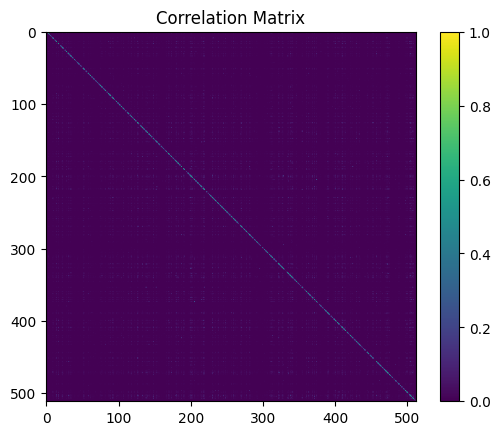

In [10]:
plt.title("Correlation Matrix");
plt.imshow(corr_mat.numpy()); plt.colorbar();
plt.savefig('./imgs/results/correlation_matrix.png', bbox_inches='tight')
plt.show()

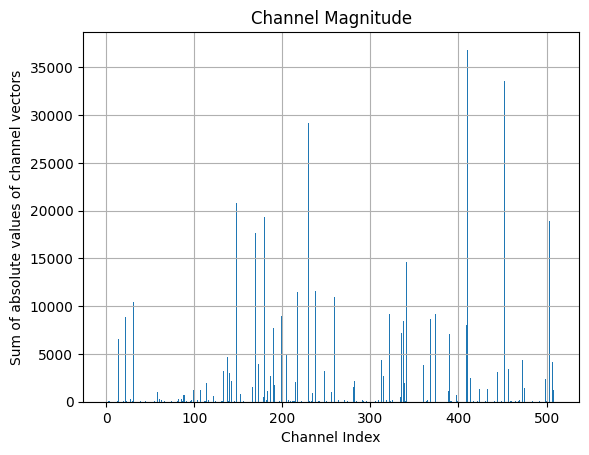

In [11]:
plt.title("Channel Magnitude")
plt.grid(); plt.xlabel("Channel Index"); 
plt.ylabel("Sum of absolute values of channel vectors")
plt.bar(range(512), channel_magnitude.numpy()); 
plt.savefig('./imgs/results/channel_magnitude.png', bbox_inches='tight')
plt.show()

In [12]:
sorted_value, indices = torch.sort(channel_magnitude)

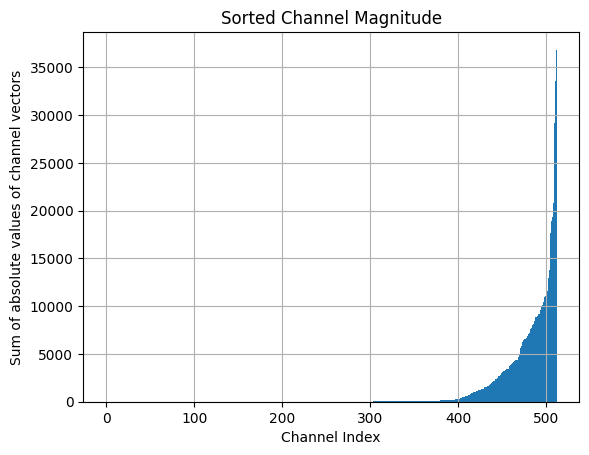

In [13]:
plt.title("Sorted Channel Magnitude")
plt.grid(); plt.xlabel("Channel Index"); 
plt.ylabel("Sum of absolute values of channel vectors")
plt.bar(range(512), sorted_value.tolist(), width=1.0)
plt.savefig('./imgs/results/sorted_channel_magnitude.png', bbox_inches='tight')
plt.show()

In [14]:
with open('./model-store/with_uncorr/channel_indices.txt', 'w') as f:
    for i in indices:
        f.write(f"{i.item()}\n")

### Channel Pruning

In [15]:
import copy
from utils import calc_num_params
from prune import prune_style_transfer_network

In [16]:
content_img = imload('./imgs/content/lena.jpg', imsize=512, cropsize=512, cencrop=True)
style_img = imload('./imgs/style/mondrian.jpg', imsize=512, cropsize=512, cencrop=True)

In [17]:
print(f"Number of parameters before pruning: {calc_num_params(model)}")
results = []
# number of channels to prune
nums = [0, 100, 200, 300, 400, 470, 490, 500]
for num in nums:
    
    pruned_model = copy.deepcopy(model).cpu()
    prune_style_transfer_network(pruned_model, indices[:num].tolist())
    print(f"Number of parameters after pruning ({num} channels): {calc_num_params(pruned_model)}")
    with torch.inference_mode():
        output = pruned_model(content=content_img, style=style_img)
        
    results.append(ten2pil(output))

Number of parameters before pruning: 7010947
Number of parameters after pruning (0 channels): 7010947
Number of parameters after pruning (100 channels): 6550047
Number of parameters after pruning (200 channels): 6089147
Number of parameters after pruning (300 channels): 5628247
Number of parameters after pruning (400 channels): 5167347
Number of parameters after pruning (470 channels): 4844717
Number of parameters after pruning (490 channels): 4752537
Number of parameters after pruning (500 channels): 4706447


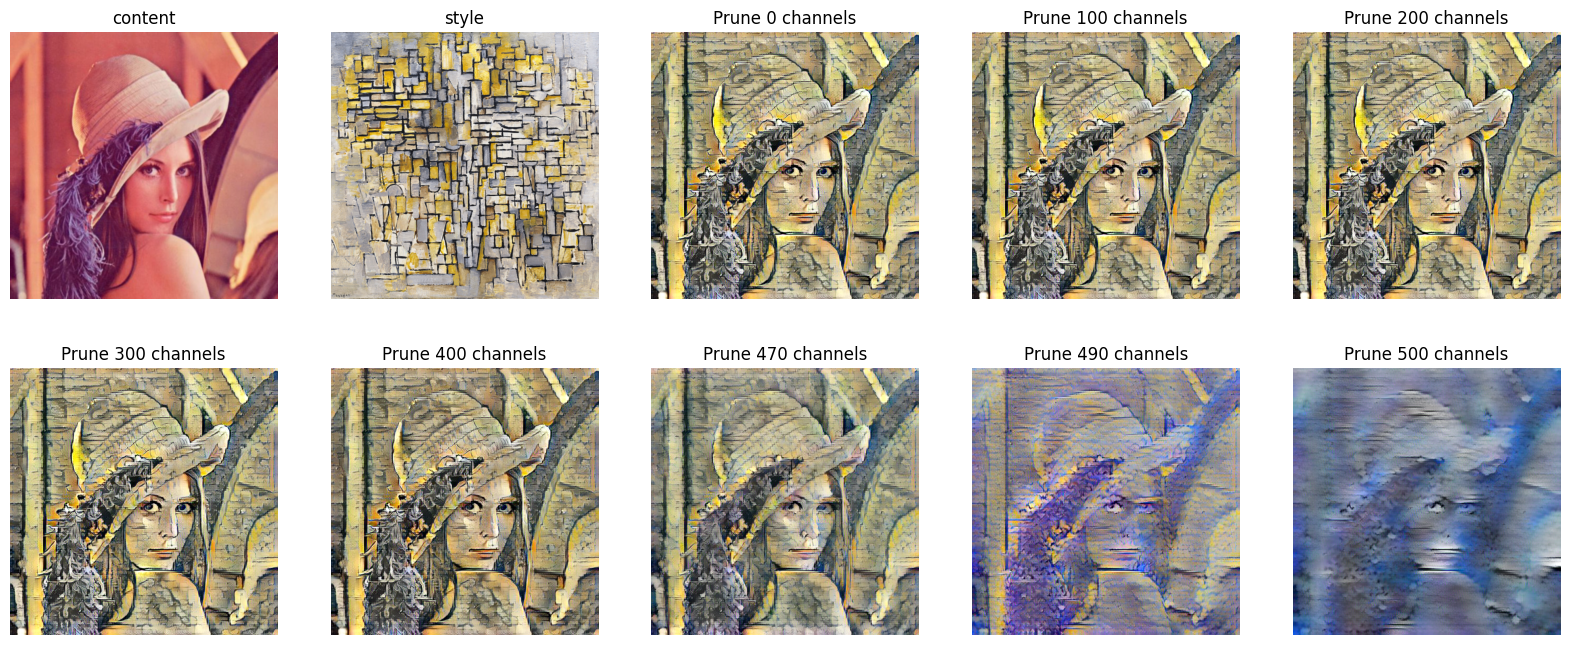

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
labels = ['content', 'style'] + [f'Prune {num} channels' for num in nums]
for index, img in enumerate([ten2pil(content_img), ten2pil(style_img)] + results):
    i, j = index // 5, index % 5
    axes[i][j].set_title(labels[index])
    axes[i][j].imshow(img)
    axes[i][j].axis('off')
plt.savefig('./imgs/results/stylization_per_prune_channels.png', bbox_inches='tight')
plt.show()